## CAPM Regression of Returns to Find Alpha & Beta ##
 **The Capital Asset Pricing Model (CAPM):**
 
 $$
 \mathbb{E}[R_i] = r_f + \beta_i \big(\mathbb{E}[R_m] - r_f\big)
 $$
 
 - $\mathbb{E}[R_i]$ : Expected return of asset $i$
 - $r_f$ : Risk-free rate   
 - $\beta_i$ : Sensitivity (“beta”) of $i$ to market returns
 - $\mathbb{E}[R_m]$ : Expected market return
 - $\big(\mathbb{E}[R_m] - r_f\big)$ : Market risk premium
 
Goal of this project: Run a regression to see how much of the fund's returns are explained by the market

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [85]:
# Pull historical data from yfinance starting from the year 2000
df = yf.download("ACWI", start="2000-01-01", multi_level_index=False) #MSCI ACWI index
df['market_rets'] = df['Close'].pct_change()
df = df.dropna()
display(df.head())
display(df.tail())

[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume,market_rets
Date,,,,,,
2008-03-31,35.113647,35.597777,35.113647,35.597777,400,-0.015569
2008-04-01,36.060547,36.060547,35.711687,35.775764,600,0.026967
2008-04-02,36.459248,36.594521,36.345335,36.395171,10700,0.011056
2008-04-03,36.665707,42.503742,36.274132,42.503742,29100,0.005663
2008-04-04,36.644360,39.121965,36.644360,39.121965,9900,-0.000582


,Close,High,Low,Open,Volume,market_rets
Date,,,,,,
2026-02-04,144.990005,146.250000,144.169998,146.149994,6793500,-0.003779
2026-02-05,143.210007,144.539993,142.919998,143.809998,4062200,-0.012277
2026-02-06,146.279999,146.470001,144.419998,144.460007,4312200,0.021437
2026-02-09,147.410004,147.679993,146.039993,146.279999,3577700,0.007725
2026-02-10,147.309998,148.009995,147.240005,147.820007,6699600,-0.000678


In [86]:
#Get returns data (depends on fund)
fund_data = pd.read_csv("C:/Users/admin/Desktop/Python Projects/seldon-capital-returns.csv")
fund_data = fund_data[['Date', 'Net Return']].dropna()

# Prepare fund returns
fund_data['Date'] = pd.to_datetime(fund_data['Date'])
fund_data = fund_data.set_index('Date').sort_index()
fund_data['Net Return'] = fund_data['Net Return'].str.rstrip('%').astype('float') / 100

display(fund_data.head())
display(fund_data.tail())

C:\Users\admin\AppData\Local\Temp\ipykernel_26516\2179057811.py:6: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  fund_data['Date'] = pd.to_datetime(fund_data['Date'])


,Net Return
Date,
2021-04-30,-0.0229
2021-05-31,0.0174
2021-06-30,-0.0391
2021-07-31,0.0398
2021-08-31,-0.0019


,Net Return
Date,
2025-08-31,0.0174
2025-09-30,-0.0157
2025-10-31,0.0619
2025-11-30,0.0469
2025-12-31,0.0010


C:\Users\admin\AppData\Local\Temp\ipykernel_26516\1121197111.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  market_rets = df['market_rets'].resample('M').apply(lambda x: (1 + x).prod() - 1)


Date
2021-04-30   -0.0229
2021-05-31    0.0174
2021-06-30   -0.0391
2021-07-31    0.0398
2021-08-31   -0.0019
2021-09-30    0.0136
2021-10-31    0.0388
2021-11-30   -0.0107
2021-12-31    0.0205
2022-01-31   -0.0101
2022-02-28    0.0328
2022-03-31    0.0127
2022-04-30   -0.0191
2022-05-31    0.0115
2022-06-30   -0.0146
2022-07-31   -0.0402
2022-08-31    0.0374
2022-09-30   -0.0136
2022-10-31   -0.0067
2022-11-30   -0.0129
2022-12-31    0.0160
2023-01-31   -0.0085
2023-02-28   -0.0133
2023-03-31    0.0187
2023-04-30    0.0369
2023-05-31    0.0050
2023-06-30    0.0315
2023-07-31    0.0206
2023-08-31    0.0385
2023-09-30    0.0006
2023-10-31    0.0130
2023-11-30    0.0091
2023-12-31   -0.0143
2024-01-31    0.0426
2024-02-29    0.0283
2024-03-31    0.0434
2024-04-30   -0.0011
2024-05-31    0.0254
2024-06-30   -0.0256
2024-07-31    0.0010
2024-08-31   -0.0163
2024-09-30    0.0008
2024-10-31   -0.0252
2024-11-30    0.0459
2024-12-31    0.0053
2025-01-31    0.0311
2025-02-28    0.0120
2025-03-

Date
2021-04-30    0.042459
2021-05-31    0.014719
2021-06-30    0.012609
2021-07-31    0.009092
2021-08-31    0.021741
2021-09-30   -0.042270
2021-10-31    0.053943
2021-11-30   -0.023075
2021-12-31    0.038879
2022-01-31   -0.045472
2022-02-28   -0.030603
2022-03-31    0.019412
2022-04-30   -0.080678
2022-05-31    0.004470
2022-06-30   -0.081069
2022-07-31    0.070688
2022-08-31   -0.043643
2022-09-30   -0.093946
2022-10-31    0.063472
2022-11-30    0.083363
2022-12-31   -0.046100
2023-01-31    0.075047
2023-02-28   -0.033205
2023-03-31    0.033326
2023-04-30    0.015687
2023-05-31   -0.010476
2023-06-30    0.057843
2023-07-31    0.035960
2023-08-31   -0.029077
2023-09-30   -0.042798
2023-10-31   -0.025441
2023-11-30    0.088869
2023-12-31    0.048128
2024-01-31    0.002751
2024-02-29    0.045076
2024-03-31    0.032630
2024-04-30   -0.035503
2024-05-31    0.045754
2024-06-30    0.020378
2024-07-31    0.015391
2024-08-31    0.024972
2024-09-30    0.021970
2024-10-31   -0.020912
2024-1

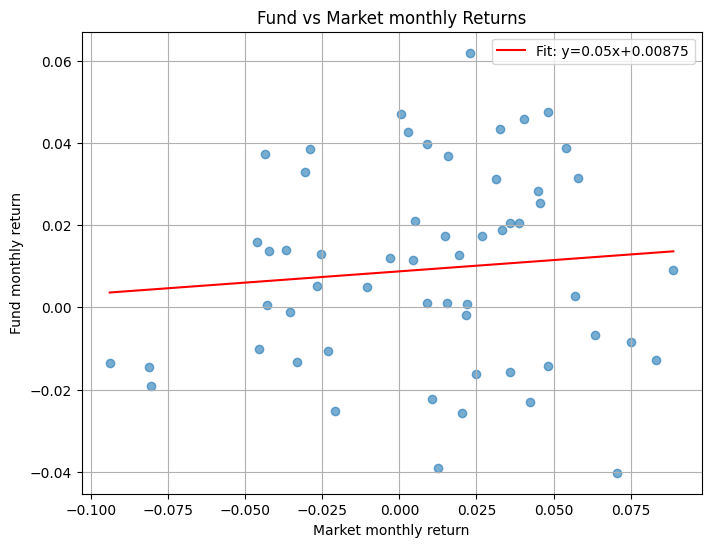

beta = 0.0548, alpha = 0.008754, R^2 = 0.0091


In [87]:

#get fund returns and market returns
fund_rets = fund_data['Net Return']
market_rets = df['market_rets'].resample('M').apply(lambda x: (1 + x).prod() - 1)

# Align series on common dates
rets, market_rets = fund_rets.align(market_rets, join='inner')
rets = rets.dropna()
market_rets = market_rets.dropna()

display(rets)
display(market_rets)

# Regression (beta, alpha) and line-of-best-fit
m, c = np.polyfit(market_rets, rets, 1) #fit on y = mx + c linear regression
y_fit = m * market_rets + c
corr = np.corrcoef(market_rets, rets)[0,1]
r2 = corr**2

# Scatter + fitted line
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(market_rets, rets, alpha=0.6)
# plot fitted line sorted by market returns for a clean line
idx = np.argsort(market_rets)
plt.plot(market_rets.iloc[idx], y_fit.iloc[idx], color='red', label=f'Fit: y={m:.2f}x+{c:.5f}')
plt.xlabel('Market monthly return')
plt.ylabel('Fund monthly return')
plt.title('Fund vs Market monthly Returns')
plt.legend()
plt.grid(True)
plt.show()

print(f'beta = {m:.4f}, alpha = {c:.6f}, R^2 = {r2:.4f}')